## Multivariate Multi-step Time Series Forecasting using Stacked LSTM sequence to sequence Autoencoder in Tensorflow 2.0 / Keras
Modified code from: https://www.analyticsvidhya.com/blog/2020/10/multivariate-multi-step-time-series-forecasting-using-stacked-lstm-sequence-to-sequence-autoencoder-in-tensorflow-2-0-keras/

In [59]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [60]:
bapok_df = pd.read_csv('harga_bapokting_surabaya.csv')

In [61]:
#checking for null values
bapok_df.isna().sum()

Tanggal                        0
Beras Premium                  0
Beras Medium                   0
Beras SPHP                     0
Jagung Tk Peternak             0
Kedelai Biji Kering (Impor)    0
Bawang Merah                   0
Bawang Putih Bonggol           0
Cabai Merah Keriting           0
Cabai Merah Besar              0
Daging Sapi Murni              0
Cabai Rawit Merah              0
Daging Ayam Ras                0
Telur Ayam Ras                 0
Gula Konsumsi                  0
Minyak Goreng Kemasan          0
Minyak Goreng Curah            0
Tepung Terigu (Curah)          0
Minyakita                      0
Tepung Terigu Kemasan          0
Ikan Kembung                   0
Ikan Tongkol                   0
Ikan Bandeng                   0
Garam Konsumsi                 0
Daging Kerbau Beku (Impor)     0
Daging Kerbau Segar (Lokal)    0
dtype: int64

In [62]:
(bapok_df == 0).sum()
(bapok_df == 0).mean() * 100  # dalam persen

Tanggal                          0.000000
Beras Premium                   14.595661
Beras Medium                    14.595661
Beras SPHP                      84.418146
Jagung Tk Peternak              78.040763
Kedelai Biji Kering (Impor)     37.278107
Bawang Merah                    14.595661
Bawang Putih Bonggol            14.595661
Cabai Merah Keriting            14.595661
Cabai Merah Besar               92.636423
Daging Sapi Murni               14.595661
Cabai Rawit Merah               14.595661
Daging Ayam Ras                 14.595661
Telur Ayam Ras                  14.595661
Gula Konsumsi                   14.595661
Minyak Goreng Kemasan           14.661407
Minyak Goreng Curah             35.568705
Tepung Terigu (Curah)           14.595661
Minyakita                       92.636423
Tepung Terigu Kemasan           51.873767
Ikan Kembung                    49.638396
Ikan Tongkol                    48.191979
Ikan Bandeng                    46.679816
Garam Konsumsi                  51

In [63]:
# Hitung jumlah nilai 0 per kolom
zero_counts = (bapok_df == 0).sum()

# Hitung persentase nilai 0 per kolom
zero_percent = (bapok_df == 0).mean() * 100
# Drop kolom dengan lebih dari 15% nilai 0
threshold = 15
columns_to_drop = zero_percent[zero_percent > threshold].index
bapok_df = bapok_df.drop(columns=columns_to_drop)

# Cek ulang sisa kolom setelah drop
remaining_columns = bapok_df.columns

zero_counts_cleaned = (bapok_df == 0).sum()
zero_percent_cleaned = (bapok_df == 0).mean() * 100

remaining_columns, zero_counts_cleaned, zero_percent_cleaned

(Index(['Tanggal', 'Beras Premium', 'Beras Medium', 'Bawang Merah',
        'Bawang Putih Bonggol', 'Cabai Merah Keriting', 'Daging Sapi Murni',
        'Cabai Rawit Merah', 'Daging Ayam Ras', 'Telur Ayam Ras',
        'Gula Konsumsi', 'Minyak Goreng Kemasan', 'Tepung Terigu (Curah)'],
       dtype='object'),
 Tanggal                    0
 Beras Premium            222
 Beras Medium             222
 Bawang Merah             222
 Bawang Putih Bonggol     222
 Cabai Merah Keriting     222
 Daging Sapi Murni        222
 Cabai Rawit Merah        222
 Daging Ayam Ras          222
 Telur Ayam Ras           222
 Gula Konsumsi            222
 Minyak Goreng Kemasan    223
 Tepung Terigu (Curah)    222
 dtype: int64,
 Tanggal                   0.000000
 Beras Premium            14.595661
 Beras Medium             14.595661
 Bawang Merah             14.595661
 Bawang Putih Bonggol     14.595661
 Cabai Merah Keriting     14.595661
 Daging Sapi Murni        14.595661
 Cabai Rawit Merah        14.595

In [64]:
bapok_df = bapok_df.drop(columns=["Tepung Terigu (Curah)"])

In [65]:
bapok_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1521 entries, 0 to 1520
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Tanggal                1521 non-null   object
 1   Beras Premium          1521 non-null   int64 
 2   Beras Medium           1521 non-null   int64 
 3   Bawang Merah           1521 non-null   int64 
 4   Bawang Putih Bonggol   1521 non-null   int64 
 5   Cabai Merah Keriting   1521 non-null   int64 
 6   Daging Sapi Murni      1521 non-null   int64 
 7   Cabai Rawit Merah      1521 non-null   int64 
 8   Daging Ayam Ras        1521 non-null   int64 
 9   Telur Ayam Ras         1521 non-null   int64 
 10  Gula Konsumsi          1521 non-null   int64 
 11  Minyak Goreng Kemasan  1521 non-null   int64 
dtypes: int64(11), object(1)
memory usage: 142.7+ KB


In [66]:
#converting the dataype of 'Date' col to 'datetime'
bapok_df['Tanggal'] = pd.to_datetime(bapok_df['Tanggal'], dayfirst=True)

In [67]:
#making the 'Date' col as index
bapok_df.set_index('Tanggal', inplace = True)

In [68]:
# Fungsi untuk mengganti nol dengan rata-rata per bulan (fallback ke bulan berikut jika perlu)
def fill_zero_with_monthly_mean(df):
    df_filled = df.copy()
    
    for col in df.columns:
        for idx, value in df[col].items():
            if value == 0:
                bulan_ini = idx.to_period('M')
                nilai_bulan_ini = df_filled[col][df_filled.index.to_period('M') == bulan_ini]
                mean_bulan_ini = nilai_bulan_ini[nilai_bulan_ini != 0].mean()
                
                if pd.isna(mean_bulan_ini):  # jika bulan itu semua 0, cari bulan setelahnya
                    bulan_berikutnya = bulan_ini + 1
                    while True:
                        nilai_bulan_berikut = df_filled[col][df_filled.index.to_period('M') == bulan_berikutnya]
                        mean_bulan_berikut = nilai_bulan_berikut[nilai_bulan_berikut != 0].mean()
                        if not pd.isna(mean_bulan_berikut):
                            mean_bulan_ini = mean_bulan_berikut
                            break
                        bulan_berikutnya += 1
                
                # Bulatkan rata-rata menjadi bilangan bulat
                df_filled.at[idx, col] = int(mean_bulan_ini)  # Menggunakan int() untuk menghilangkan koma

    return df_filled

# Terapkan fungsi ini
bapok_df = fill_zero_with_monthly_mean(bapok_df)

# Cek apakah masih ada nilai 0
(bapok_df == 0).sum()


Beras Premium            0
Beras Medium             0
Bawang Merah             0
Bawang Putih Bonggol     0
Cabai Merah Keriting     0
Daging Sapi Murni        0
Cabai Rawit Merah        0
Daging Ayam Ras          0
Telur Ayam Ras           0
Gula Konsumsi            0
Minyak Goreng Kemasan    0
dtype: int64

In [69]:
bapok_df.reset_index(inplace=True)

In [70]:
bapok_df = bapok_df.drop(bapok_df.columns[0], axis=1)
bapok_df.head()

,Beras Premium,Beras Medium,Bawang Merah,Bawang Putih Bonggol,Cabai Merah Keriting,Daging Sapi Murni,Cabai Rawit Merah,Daging Ayam Ras,Telur Ayam Ras,Gula Konsumsi,Minyak Goreng Kemasan
0,12515,10500,33789,26684,52210,105000,100526,30315,22105,12000,13578
1,12515,10500,33789,26684,52210,105000,100526,30315,22105,12000,13578
2,12515,10500,33789,26684,52210,105000,100526,30315,22105,12000,13578
3,12515,10500,33789,26684,52210,105000,100526,30315,22105,12000,13578
4,12515,10500,33789,26684,52210,105000,100526,30315,22105,12000,13578


In [71]:
split_index = round(len(bapok_df.index) * 0.75) # 75%/25% train/test split
train_bapok_df, test_bapok_df = bapok_df[1:split_index], bapok_df[split_index:]

In [72]:
train = train_bapok_df.copy()  # make a copy of the original DataFrame
scalers = {}
for i in train_bapok_df.columns:
    scaler = MinMaxScaler(feature_range=(-1, 1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1, 1))
    s_s = np.reshape(s_s, len(s_s))
    scalers['scaler_' + i] = scaler
    train.loc[:, i] = s_s  # use .loc to set the values of the original DataFrame

test = test_bapok_df.copy()  # make a copy of the original DataFrame
for i in train_bapok_df.columns:
    scaler = scalers['scaler_' + i]
    s_s = scaler.transform(test[i].values.reshape(-1, 1))
    s_s = np.reshape(s_s, len(s_s))
    scalers['scaler_' + i] = scaler
    test.loc[:, i] = s_s  # use .loc to set the values of the original DataFrame

C:\Users\ASUS1\AppData\Local\Temp\ipykernel_14616\3090720493.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.64385965 -0.64385965 -0.64385965 ...  0.92982456  0.75438596
  0.57894737]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train.loc[:, i] = s_s  # use .loc to set the values of the original DataFrame
C:\Users\ASUS1\AppData\Local\Temp\ipykernel_14616\3090720493.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.4516129  -0.4516129  -0.4516129  ... -0.32258065 -0.14516129
 -0.32258065]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train.loc[:, i] = s_s  # use .loc to set the values of the original DataFrame
C:\Users\ASUS1\AppData\Local\Temp\ipykernel_14616\3090720493.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated an

In [73]:
def split_series(series, n_past, n_future):
    """
    Splits a time series into past and future windows.

    Args:
        series (numpy.ndarray): The time series to be split.
        n_past (int): The number of past observations in each window.
        n_future (int): The number of future observations in each window.

    Returns:
        tuple: A tuple of numpy arrays containing the past and future windows.
    """
    X, y = [], []  # initialize empty lists to store past and future windows
    for window_start in range(len(series)):
        past_end = window_start + n_past  # end index of past window
        future_end = past_end + n_future  # end index of future window
        if future_end > len(series):  # if future window extends beyond series, break loop
            break
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]  # slice past and future windows
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)  # convert lists to numpy arrays and return as tuple

In [74]:
n_past = 30
n_future = 15
n_features = 11

In [75]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [76]:
#E1D1

# Define Encoder input
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))

# Encoder LSTM layer with 100 units
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]

# Define decoder input
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

# Decoder LSTM layer with 100 units
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs, initial_state=encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

# Define the model
model_e1d1 = tf.keras.models.Model(encoder_inputs, decoder_outputs1)

# Print model summary
model_e1d1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 100),     │     44,800 │ input_layer[0][0] │
│                     │ (None, 100),      │            │                   │
│                     │ (None, 100)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 15, 100)   │          0 │ lstm[0][0]        │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 15, 100)   │     80,400 │ repeat_vector[0]… │
│                     │                   │            │ lstm[0][1],       │
│                     │                   │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 15, 11)    │      1,111 │ lstm_1[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 126,311 (493.40 KB)

 Trainable params: 126,311 (493.40 KB)

 Non-trainable params: 0 (0.00 B)

In [77]:
# E2D2
# n_features ==> no of features at each timestep in the data.

encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]

encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]

decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])

decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs, initial_state=encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1, initial_state=encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)

model_e2d2 = tf.keras.models.Model(encoder_inputs, decoder_outputs2)

model_e2d2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 30, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 30, 100), │     44,800 │ input_layer_1[0]… │
│                     │ (None, 100),      │            │                   │
│                     │ (None, 100)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, 100),     │     80,400 │ lstm_2[0][0]      │
│                     │ (None, 100),      │            │                   │
│                     │ (None, 100)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 15, 100)   │          0 │ lstm_3[0][0]      │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 15, 100)   │     80,400 │ repeat_vector_1[… │
│                     │                   │            │ lstm_2[0][1],     │
│                     │                   │            │ lstm_2[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 15, 100)   │     80,400 │ lstm_4[0][0],     │
│                     │                   │            │ lstm_3[0][1],     │
│                     │                   │            │ lstm_3[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 15, 11)    │      1,111 │ lstm_5[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 287,111 (1.10 MB)

 Trainable params: 287,111 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

In [78]:
history1 = tf.keras.callbacks.History()
history2 = tf.keras.callbacks.History()

reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

print("Training E1D1")
model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e1d1=model_e1d1.fit(X_train, y_train, epochs=25, verbose=2, validation_data=(X_test,y_test), batch_size=32 ,callbacks=[reduce_lr, history1])

print()
print("Training E2D2")
model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2=model_e2d2.fit(X_train, y_train, epochs=25, verbose=2, validation_data=(X_test,y_test), batch_size=32, callbacks=[reduce_lr, history2])

Training E1D1
Epoch 1/25
35/35 - 3s - 94ms/step - loss: 0.0342 - val_loss: 0.0283 - learning_rate: 1.0000e-03
Epoch 2/25
35/35 - 1s - 17ms/step - loss: 0.0137 - val_loss: 0.0241 - learning_rate: 9.0000e-04
Epoch 3/25
35/35 - 1s - 16ms/step - loss: 0.0118 - val_loss: 0.0276 - learning_rate: 8.1000e-04
Epoch 4/25
35/35 - 1s - 17ms/step - loss: 0.0107 - val_loss: 0.0233 - learning_rate: 7.2900e-04
Epoch 5/25
35/35 - 1s - 17ms/step - loss: 0.0100 - val_loss: 0.0283 - learning_rate: 6.5610e-04
Epoch 6/25
35/35 - 1s - 16ms/step - loss: 0.0091 - val_loss: 0.0343 - learning_rate: 5.9049e-04
Epoch 7/25
35/35 - 1s - 16ms/step - loss: 0.0086 - val_loss: 0.0382 - learning_rate: 5.3144e-04
Epoch 8/25
35/35 - 1s - 16ms/step - loss: 0.0081 - val_loss: 0.0382 - learning_rate: 4.7830e-04
Epoch 9/25
35/35 - 1s - 16ms/step - loss: 0.0078 - val_loss: 0.0374 - learning_rate: 4.3047e-04
Epoch 10/25
35/35 - 1s - 16ms/step - loss: 0.0074 - val_loss: 0.0393 - learning_rate: 3.8742e-04
Epoch 11/25
35/35 - 1s - 

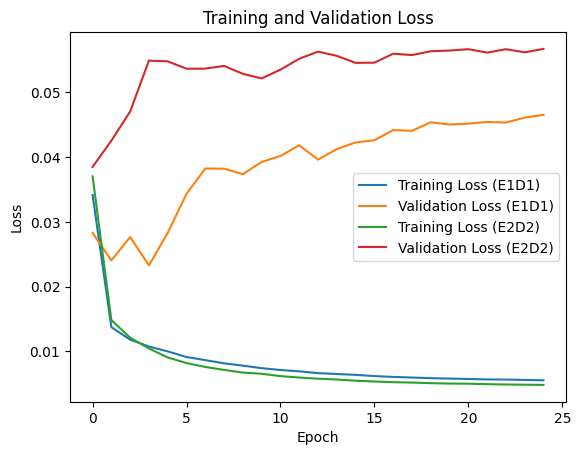

In [79]:
# plot the training and validation loss for each model
plt.plot(history1.history['loss'], label='Training Loss (E1D1)')
plt.plot(history1.history['val_loss'], label='Validation Loss (E1D1)')

plt.plot(history2.history['loss'], label='Training Loss (E2D2)')
plt.plot(history2.history['val_loss'], label='Validation Loss (E2D2)')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

plt.legend()
plt.show()

In [80]:
pred1_e1d1=pred_e1d1=model_e1d1.predict(X_test)
pred1_e2d2=pred_e2d2=model_e2d2.predict(X_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


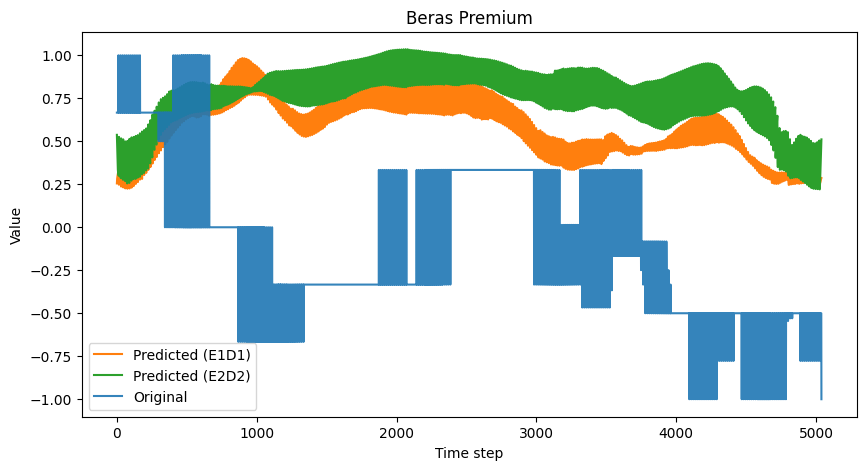

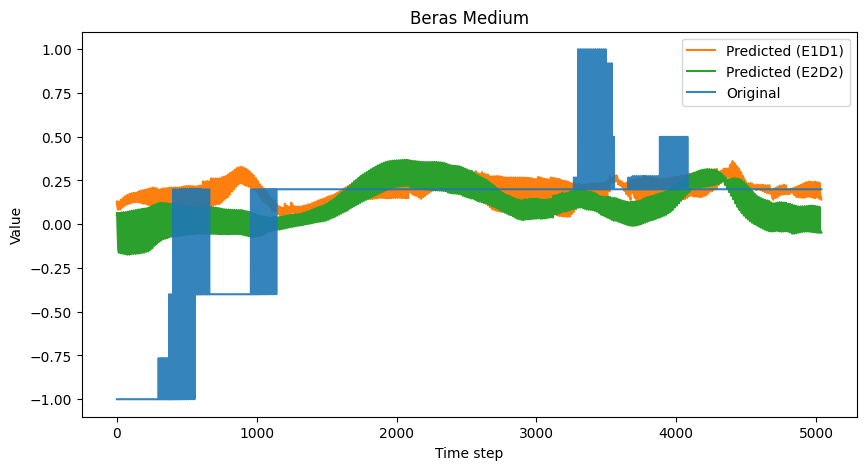

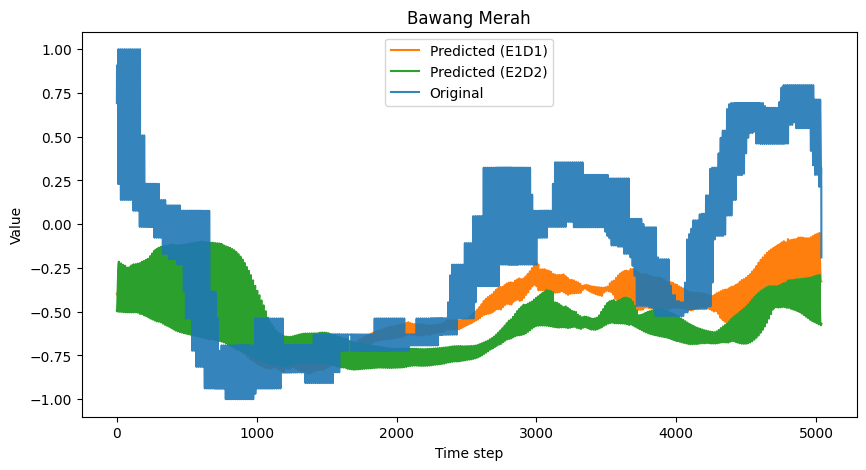

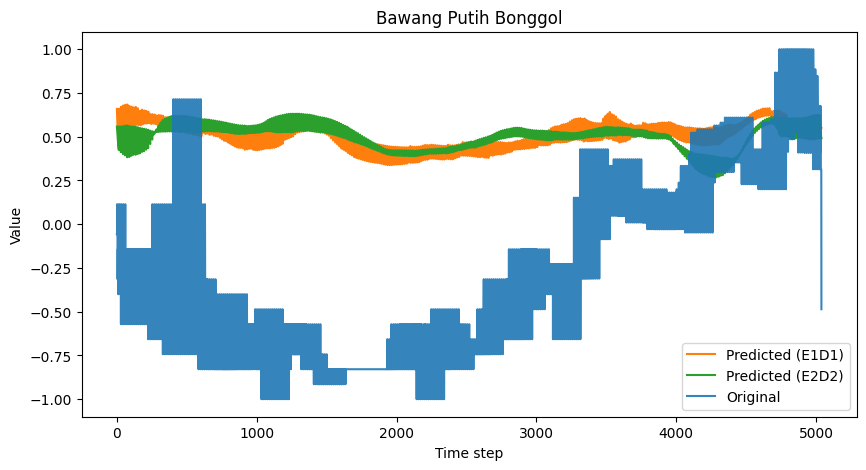

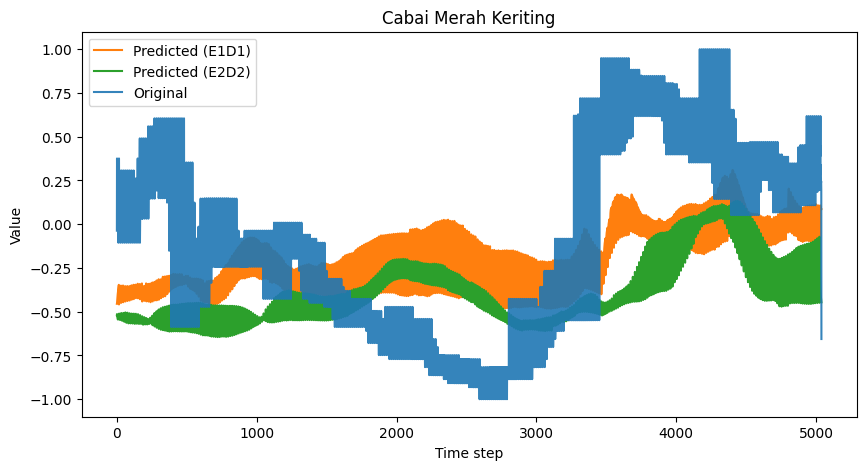

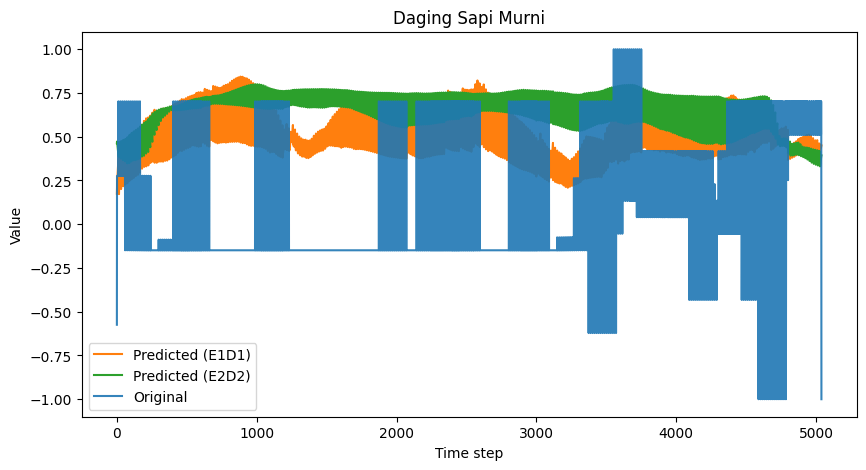

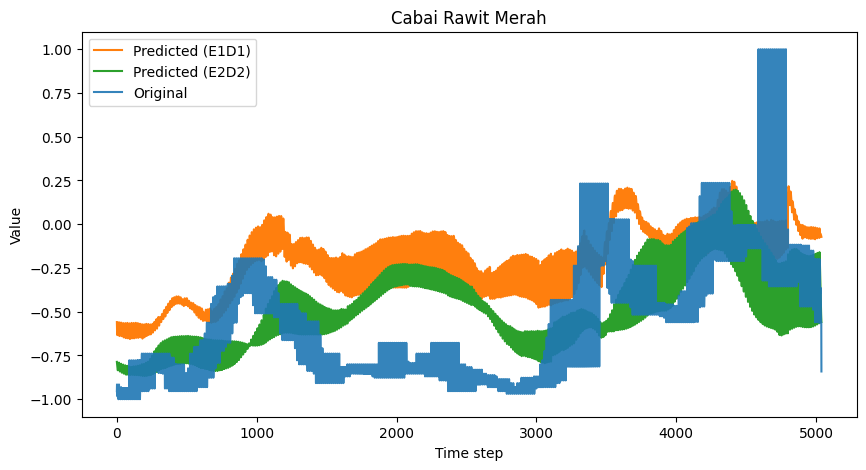

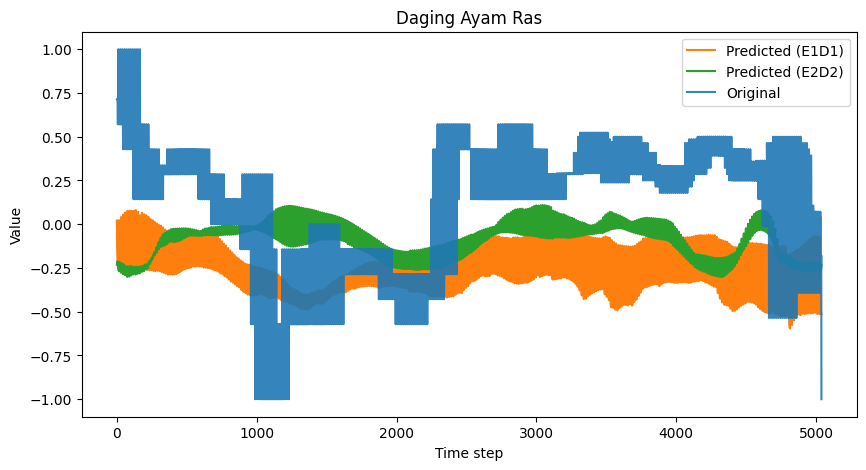

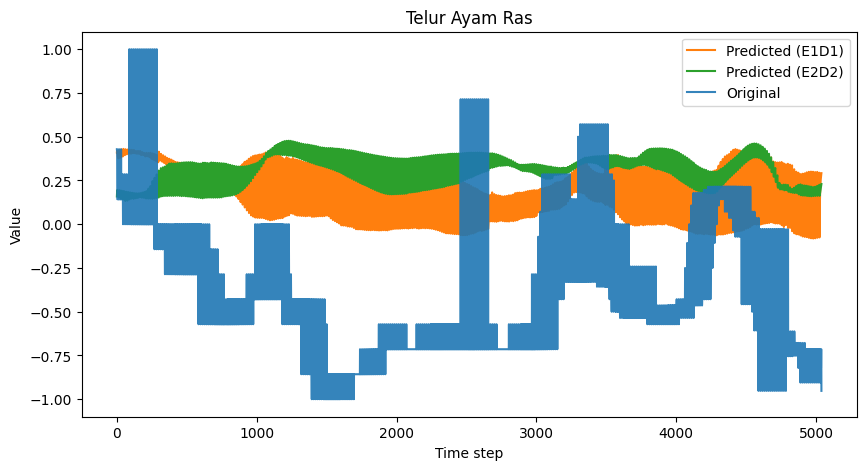

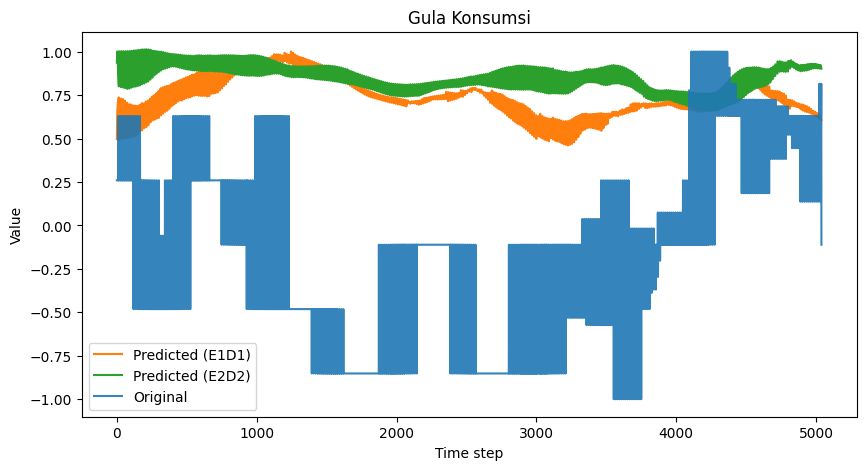

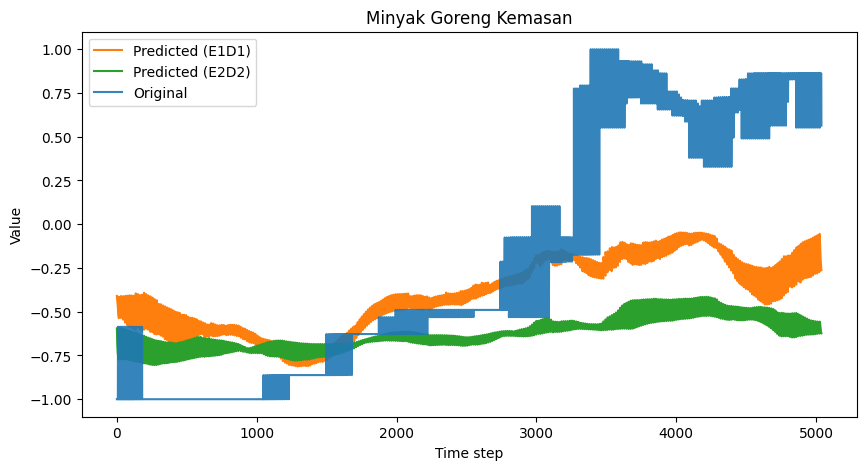

In [81]:
import matplotlib.pyplot as plt

for index,i in enumerate(train_bapok_df.columns):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(pred1_e1d1[:, :, index].flatten(), label='Predicted (E1D1)', color="C1")
    ax.plot(pred1_e2d2[:, :, index].flatten(), label='Predicted (E2D2)', color="C2")
    vals = y_test[:, :, index].reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    vals = scaler.fit_transform(vals)
    ax.plot(vals, label='Original', color="C0", alpha=0.9)
    ax.set_xlabel('Time step')
    ax.set_ylabel('Value')
    ax.set_title(train_bapok_df.columns[index])
    ax.legend()
    plt.show()